https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one

https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two

In [97]:
import pandas as pd
import numpy as np
# Import the data
df = pd.read_csv("UsdArsivSatis.csv", delimiter=';')
df


,Tarih,GiseSatis
0,03-01-2022,13.27500000
1,04-01-2022,13.54000000
2,05-01-2022,13.65800000
3,06-01-2022,13.86100000
4,07-01-2022,13.88400000
...,...,...
351,27-12-2022,18.82800000
352,28-12-2022,18.87600000
353,29-12-2022,18.91600000
354,30-12-2022,18.90200000


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tarih      356 non-null    object 
 1   GiseSatis  356 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.7+ KB


In [99]:
df['Tarih'] = pd.to_datetime(df['Tarih'])


C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_12308\1485460673.py:1: UserWarning: Parsing '13-01-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Tarih'] = pd.to_datetime(df['Tarih'])
C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_12308\1485460673.py:1: UserWarning: Parsing '14-01-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Tarih'] = pd.to_datetime(df['Tarih'])
C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_12308\1485460673.py:1: UserWarning: Parsing '15-01-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Tarih'] = pd.to_datetime(df['Tarih'])
C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_12308\1485460673.py:1: UserWarning: Parsing '16-01-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Tarih'] = pd.to_datetime(df['Tarih'])
C:\Users\TOSHIBA

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Tarih      356 non-null    datetime64[ns]
 1   GiseSatis  356 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.7 KB


In [101]:
# Set the date as index 
df = df.set_index('Tarih')
# Select the proper time period for weekly aggreagation
df = df['2022-01-03':'2022-12-31'].resample('D').sum()
df.head()

,GiseSatis
Tarih,
2022-01-03,13.94600000
2022-01-04,14.69900000
2022-01-05,14.96600000
2022-01-06,16.44600000
2022-01-07,16.82400000


Visualize the Data

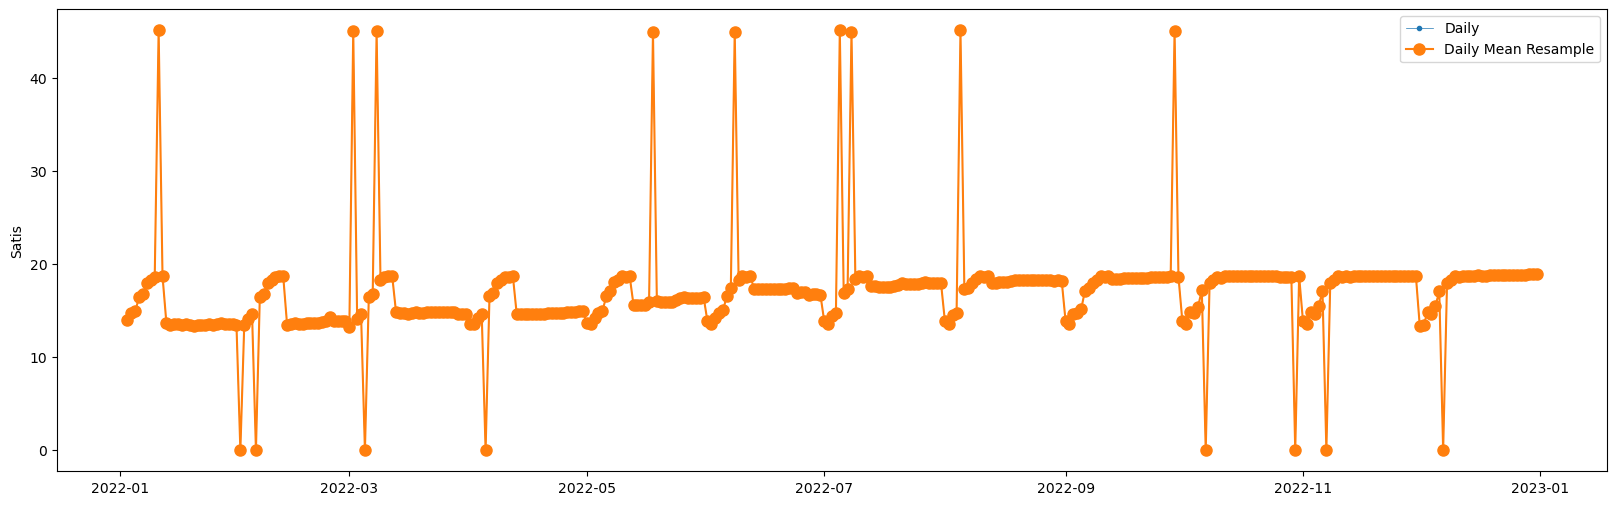

In [102]:
import warnings
import matplotlib.pyplot as plt
y = df['GiseSatis']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('D').mean(),marker='o', markersize=8, linestyle='-', label='Daily Mean Resample')
ax.set_ylabel('Satis')
ax.legend();

Decompose the Data

In [103]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

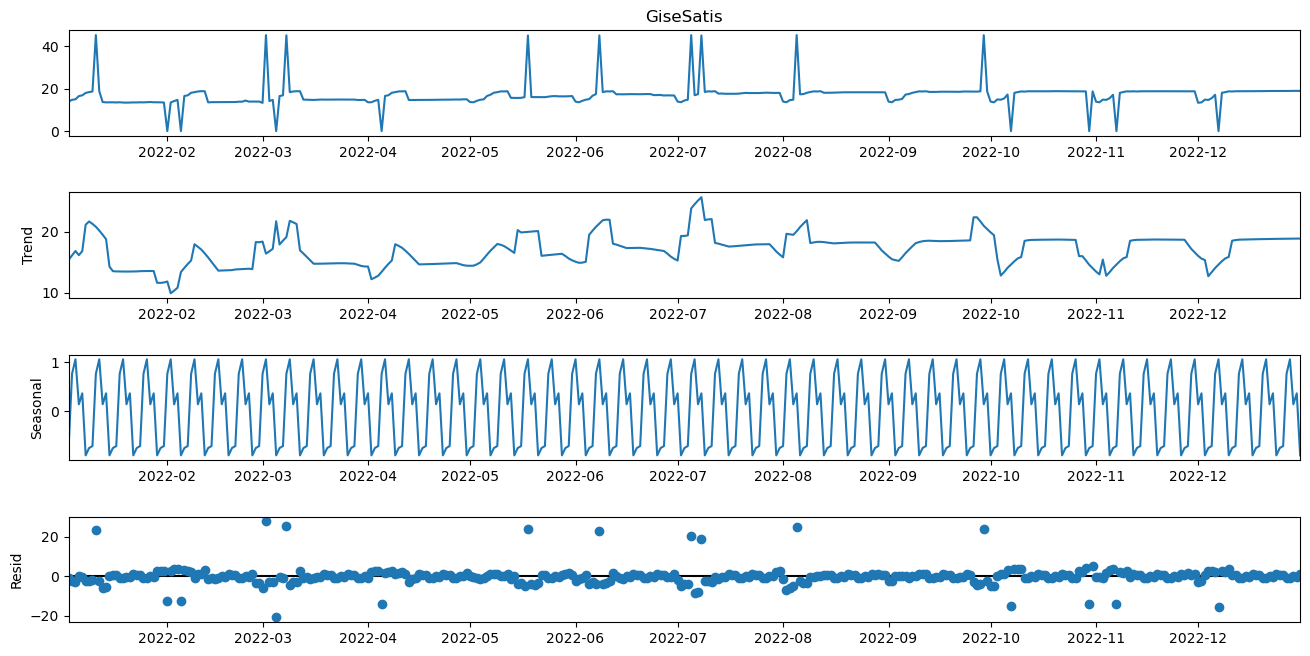

In [104]:
seasonal_decompose(y)

Check for Stationarity

This method graphs the rolling statistics (mean and variance) to show at a glance whether the standard deviation changes substantially over time:

In [105]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=3).mean() 
    rolstd = pd.Series(timeseries).rolling(window=3).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

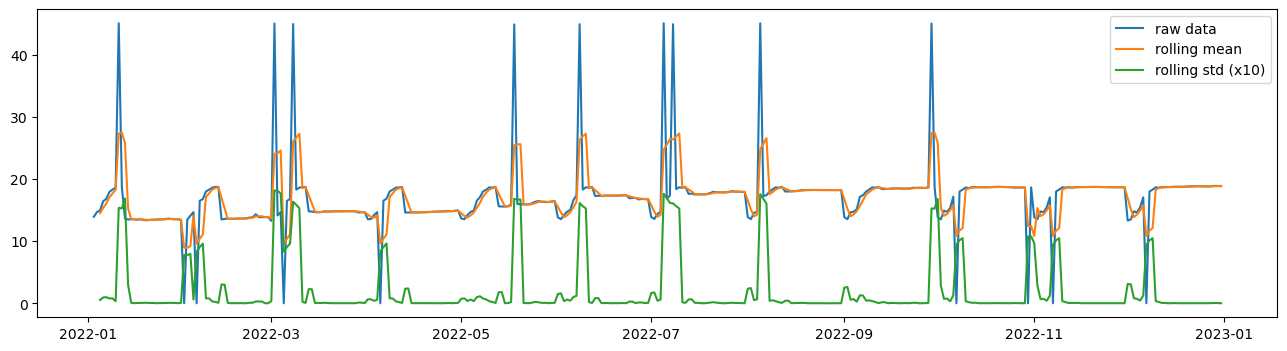

In [106]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

Augmented Dickey-Fuller Test

The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence.

In [107]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [108]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -11.587
P-value = 0.000
Critical values :
	1%: -3.4485948978753314 - The data is  stationary with 99% confidence
	5%: -2.86957971128312 - The data is  stationary with 95% confidence
	10%: -2.571053050314224 - The data is  stationary with 90% confidence


The results show that the data is now stationary, indicated by the relative smoothness of the rolling mean and rolling standard deviation after running the ADF test again.

Differencing

This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 12-month seasonality, I used a 12-lag difference:

 > Is the 3 lag differenced data stationary ?
Test statistic = -7.390
P-value = 0.000
Critical values :
	1%: -3.4496162602188187 - The data is  stationary with 99% confidence
	5%: -2.870028369720798 - The data is  stationary with 95% confidence
	10%: -2.5712922615505627 - The data is  stationary with 90% confidence


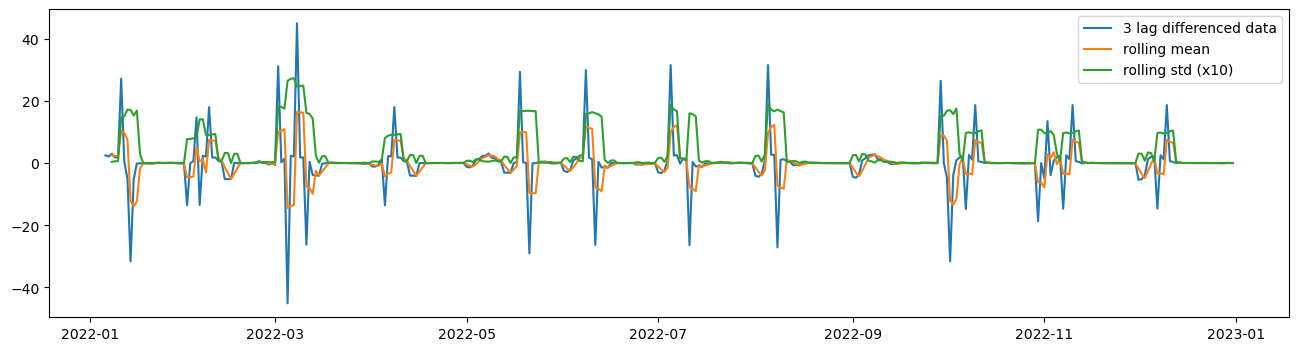

In [109]:
# Differencing
y_3lag =  y - y.shift(3)

test_stationarity(y_3lag,'3 lag differenced data')
ADF_test(y_3lag,'3 lag differenced data')

Create Training & Testing Datasets

One part will be the ‘Training’ dataset, and the other part will be the ‘Testing’ dataset. Sometimes you will create a third dataset or a ‘Validation’ dataset which reserves some data for additional testing.

In [110]:
y_to_train = y[:'2022-10-31'] # dataset to train
y_to_val = y['2022-11-01':] # last X months for test  
predict_date = len(y) - len(y[:'2022-12-01']) # the number of data points for the test set

SARIMA

In [111]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [112]:
sarima_grid_search(y,6)

c:\Users\TOSHIBA\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TOSHIBA\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 6) - AIC:2174.7762401050613


The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC, and we can see that SARIMA(1, 1, 1)x(1, 1, 0, 52) has the lowest AIC value. Since this method chose the best parameters, we will use this method to fit our model and compare the results with all the previous models discussed above.

In [113]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Tarih')
    ax.set_ylabel('Satis')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0767      0.083      0.921      0.357      -0.087       0.240
ma.L1         -1.0000     24.446     -0.041      0.967     -48.913      46.913
ar.S.L10      -0.4696      0.025    -18.839      0.000      -0.518      -0.421
sigma2        42.4900   1039.336      0.041      0.967   -1994.571    2079.551


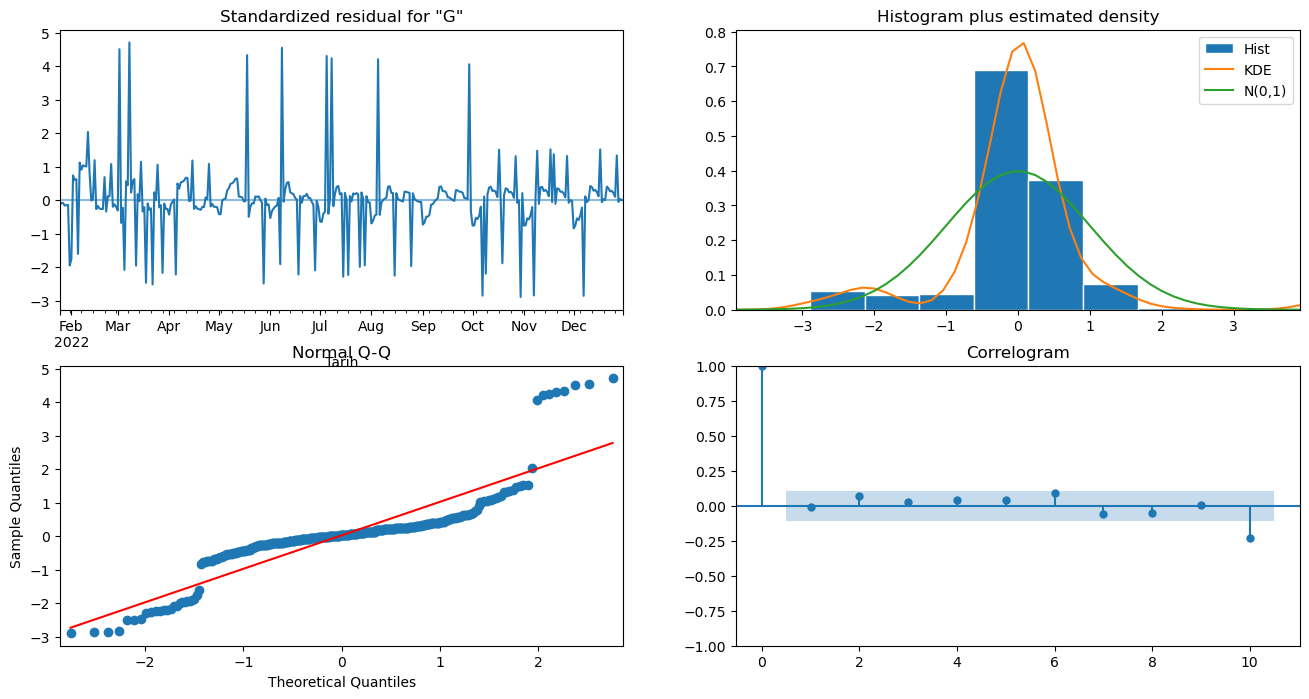

The Root Mean Squared Error of SARIMA with season_length=10 and dynamic = False 4.92


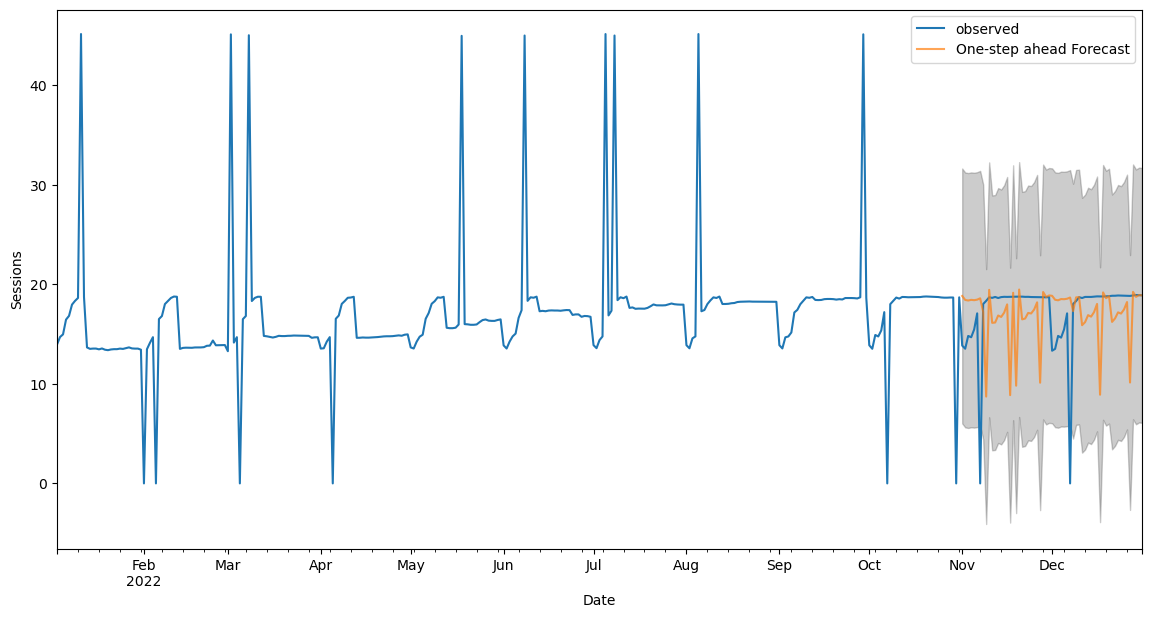

The Root Mean Squared Error of SARIMA with season_length=10 and dynamic = True 5.45


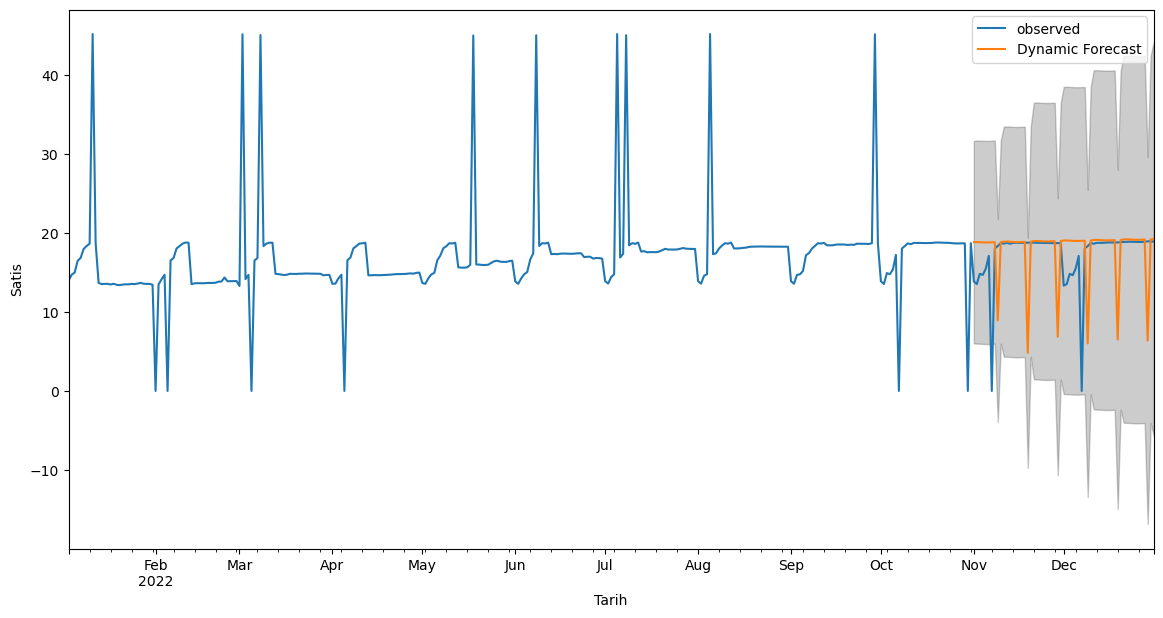

In [114]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 10),10,'2022-11-01',y_to_val)

There are a few things to check to help you get the most out of these diagnostic graphs:

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

By validating all the four points above, we can conclude that this model’s residuals are near normally distributed. This indicates we have found a well-fit model suitable for our dataset.

Making Predictions

To get the forecast for sales in the next year, we enter steps=52. The results produce both a table showing the Predicted_Mean, Lower Bound and Upper Bound, and the prediction graphs.

In [115]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Tarih')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Tarih','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Tarih','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Tarih'), on='Tarih')
    
    return (final_table)

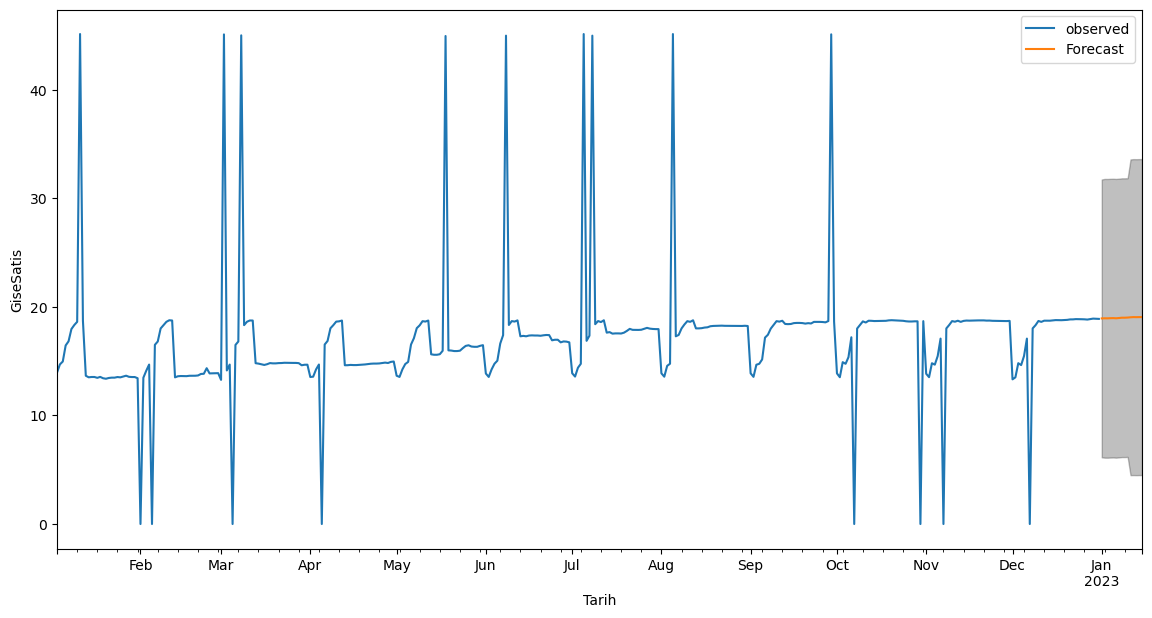

,Tarih,Predicted_Mean,Lower Bound,Upper Bound
0,2023-01-01,18.93534308,6.14081180,31.72987435
1,2023-01-02,18.94564738,6.11068433,31.78061044
2,2023-01-03,18.94217575,6.10675710,31.77759441
3,2023-01-04,18.95579162,6.12035356,31.79122969
4,2023-01-05,18.96322861,6.12778915,31.79866807
5,2023-01-06,18.94633386,6.11089429,31.78177342
6,2023-01-07,18.97179133,6.13635175,31.80723091
7,2023-01-08,19.00052007,6.16508049,31.83595964
8,2023-01-09,19.00013951,6.16469993,31.83557909
9,2023-01-10,19.01303021,6.17759064,31.84846979


In [116]:
final_table = forecast(model,15,y)
final_table.head(15)